In [1]:
import numpy as np
import pandas as pd
import time
import sys
from matplotlib import pyplot as plt
%matplotlib inline

# from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve,auc

In [2]:
#get data
in_file = '../../merge/reformatted_data_with_features.txt'
feature_type = 'TFBS_short'
metadata_columns = ['tumor_fraction','cancer_present','sample_type','Stage']

data = pd.read_csv(in_file, sep='\t')

data = data.set_index('sample')
data['status'] = data['cancer_present']

#get only the training samples used in delfi
training_samples = pd.read_csv("../../../../../metadata/cancer_detection/delfi_training_samples.txt", header=None)
data = data[data.index.isin(training_samples[0])].copy()

print(len(data))
print(data['sample_type'].value_counts())


423
Healthy              215
Breast_Cancer         54
Pancreatic_Cancer     34
Ovarian_Cancer        28
Colorectal_Cancer     27
Gastric_cancer        27
Bile_Duct_Cancer      25
Lung_Cancer           12
Duodenal_Cancer        1
Name: sample_type, dtype: int64


In [3]:
#view data
data.head()

,tumor_fraction,sample_type,cancer_present,Stage,central_cov_AHR.hg38,central_cov_AR.hg38,central_cov_ARID3A.hg38,central_cov_ARNT.hg38,central_cov_ARNTL.hg38,central_cov_ASCL1.hg38,...,mean_cov_ZNF554.hg38,mean_cov_ZNF574.hg38,mean_cov_ZNF580.hg38,mean_cov_ZNF652.hg38,mean_cov_ZNF770.hg38,mean_cov_ZNF792.hg38,mean_cov_ZSCAN16.hg38,mean_cov_ZSCAN22.hg38,mean_cov_ZSCAN9.hg38,status
sample,,,,,,,,,,,,,,,,,,,,,
Bile_Duct_Cancer_CGPLPA114,0.00000,Bile_Duct_Cancer,1,II,0.942875,1.026955,0.991088,1.016242,1.236727,1.180248,...,0.993869,0.949510,0.954177,0.974082,0.976235,0.944079,0.982950,0.957275,0.939718,1
Bile_Duct_Cancer_CGPLPA115,0.14790,Bile_Duct_Cancer,1,IV,0.944185,1.067065,1.002887,0.941577,1.181505,1.177367,...,1.001352,0.960223,0.963089,0.979000,0.969055,0.955361,0.980728,0.952814,0.954916,1
Bile_Duct_Cancer_CGPLPA117,0.00000,Bile_Duct_Cancer,1,II,0.940755,1.011755,0.956063,0.916670,1.166008,1.172052,...,0.988798,0.945592,0.951031,0.976425,0.972218,0.948751,0.962115,0.932324,0.947059,1
Bile_Duct_Cancer_CGPLPA118,0.03099,Bile_Duct_Cancer,1,I,0.962150,1.048180,0.950823,0.934817,1.145088,1.135670,...,0.981905,0.937202,0.939267,0.973045,0.977633,0.929938,0.968953,0.936086,0.928554,1
Bile_Duct_Cancer_CGPLPA122,0.04570,Bile_Duct_Cancer,1,II,0.938555,0.999495,0.881585,0.925492,1.218435,1.188130,...,0.988674,0.921989,0.917320,0.954359,0.966355,0.899037,0.988922,0.921625,0.895779,1


In [4]:
#get a list of all possible features
features = data.columns.drop(['status']+metadata_columns)

#these two should be the seame
print(len(features))
print(len(features[features.str.contains('fft_10_magnitude')])*3)

1014
1014


In [5]:
#scale data
scaler = StandardScaler()
scaler.fit(data[features])
data[features] = scaler.transform(data[features])
data[features].mean()

central_cov_AHR.hg38      -2.397216e-15
central_cov_AR.hg38       -1.522292e-17
central_cov_ARID3A.hg38    6.669212e-16
central_cov_ARNT.hg38      2.248792e-15
central_cov_ARNTL.hg38     1.919137e-15
                               ...     
mean_cov_ZNF770.hg38      -1.326703e-14
mean_cov_ZNF792.hg38       4.567925e-15
mean_cov_ZSCAN16.hg38      8.085993e-15
mean_cov_ZSCAN22.hg38      6.704645e-16
mean_cov_ZSCAN9.hg38       6.244020e-15
Length: 1014, dtype: float64

In [6]:
#Leave one out nested cross validation
hyperparameters = {'C': [0.00001, 0.0001, 0.001,0.01,0.1,1,10,100]}

start_time = time.time()
n_iter = 1000

probabilities = pd.DataFrame(index=data.index)
c_vals = []
coefs = pd.DataFrame(index=features)

# Loop for each iteration
for i in range(n_iter):
    if i%50==0:
        print(i, time.time()-start_time)
        sys.stdout.flush()
    
    #bootstrap a training set with replacement
    training = data.sample(len(data), replace = True, random_state = i+100)
    
    #the test set is all samples that aren't seen in the training data
    test = data[~(data.index.isin(training.index))]
        
    #10 fold cross validation on the training set
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = i+100) 

    model = LogisticRegression(class_weight='balanced', max_iter=500)
    search = GridSearchCV(estimator=model, param_grid=hyperparameters, cv=cv, n_jobs = 4)
    search.fit(training[features], training['status'])
    best_C = search.best_params_['C']
    
    #train a new model on the full training dataset (is this the same as refit...?)
    model = LogisticRegression(class_weight='balanced', max_iter=500, C=best_C)
    model.fit(training[features], training['status'])

    #predict the test data
    pred = model.predict(test[features])
    prob = model.predict_proba(test[features])

    
    #collect metrics
    current_output = pd.DataFrame(test[['status']])#.reset_index()
    current_output['probability']=prob[:,1]
    
    #save results
    probabilities[i] = current_output['probability']
    c_vals.append(best_C)
    coefs[i] = pd.Series(model.coef_[0], index = features)

probabilities = probabilities.merge(data[metadata_columns+['status']], left_index=True, right_index=True)

0 0.0012211799621582031
50 60.558253049850464
100 121.1874041557312
150 184.06242895126343
200 247.5542290210724
250 310.40724205970764
300 373.13608407974243
350 436.70481300354004
400 497.4267508983612
450 557.5989220142365
500 621.0930581092834
550 685.2245349884033
600 749.162693977356
650 813.5541410446167
700 876.5484018325806
750 938.7642879486084
800 1000.763023853302
850 1063.7292931079865
900 1125.7296907901764
950 1192.0288090705872


In [7]:
probabilities.to_csv(feature_type+'_results/probabilities.txt', sep='\t')
pd.Series(c_vals).to_csv(feature_type+'_results/c_values.txt', sep='\t', header = False, index=False)
coefs.to_csv(feature_type+'_results/coefs.txt', sep='\t')

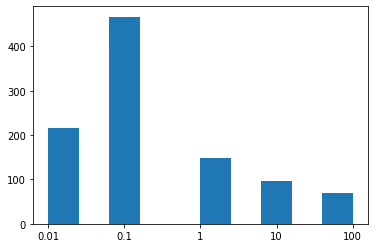

In [8]:
plt.hist([str(m) for m in sorted(c_vals)])
plt.savefig(feature_type+'_results/cvals.pdf')